In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 保留需要的列并保存到cleaned_data
path = "./dataset/USvideos.csv"
columns = ['title', 'description', 'category_id', 'tags']
data = pd.read_csv(path, usecols=columns, nrows=6000)

data['description'] = data['description'].fillna('') 
data['tags'] = data['tags'].fillna('') 
data['text'] = data['title'] + ' ' + data['description'] 
data = data.dropna(subset=['category_id'])
print(data)

cleaned_data = data[['text', 'category_id', 'tags']].copy()
cleaned_data.to_csv("./dataset/cleaned_data.csv", index=False)

                                                  title  category_id  \
0                    WE WANT TO TALK ABOUT OUR MARRIAGE           22   
1     The Trump Presidency: Last Week Tonight with J...           24   
2     Racist Superman | Rudy Mancuso, King Bach & Le...           23   
3                      Nickelback Lyrics: Real or Fake?           24   
4                              I Dare You: GOING BALD!?           24   
...                                                 ...          ...   
5995                    Runaway Bride | Hannah Stocking           23   
5996  21 Things that Turned 21 This Year (2017) - me...           27   
5997        Dad Reacts to Steelers vs Bengals (Week 13)           23   
5998     California wildfires prompt state of emergency           25   
5999  70 People Try 70 Tongue-Twisters From 70 Count...           19   

                                                   tags  \
0                                       SHANtell martin   
1     last week t

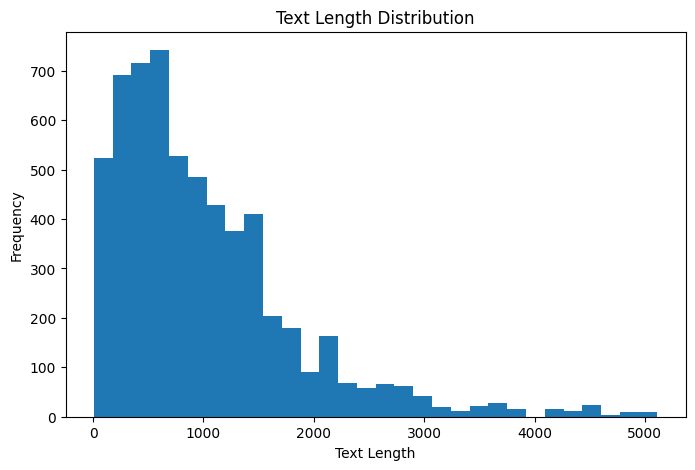

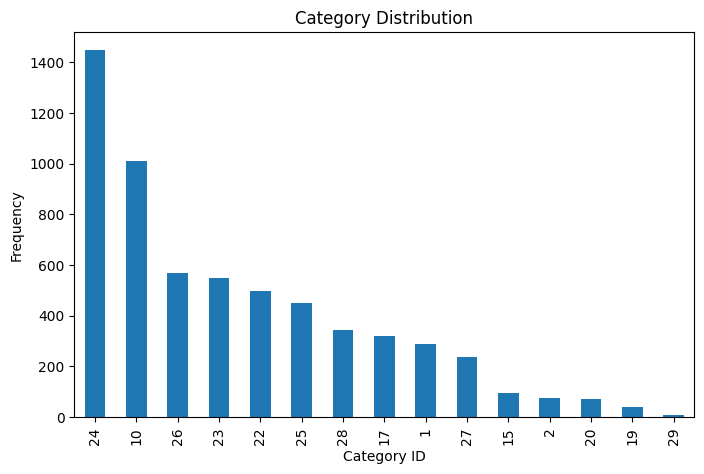

In [2]:
import matplotlib.pyplot as plt

cleaned_data['text_length'] = cleaned_data['text'].apply(len)

category_counts = cleaned_data['category_id'].value_counts()

plt.figure(figsize=(8, 5))
plt.hist(cleaned_data['text_length'], bins=30)
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar')
plt.title("Category Distribution")
plt.xlabel("Category ID")
plt.ylabel("Frequency")
plt.show()

In [3]:
from sklearn.model_selection import train_test_split

# 80%/20%
train_data, test_data = train_test_split(cleaned_data, test_size=0.2, random_state=0)
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

train_data.to_csv("./dataset/train_data.csv", index=False)
test_data.to_csv("./dataset/test_data.csv", index=False)

# 是否能反映全集
train_category_counts = train_data['category_id'].value_counts(normalize=True)
test_category_counts = test_data['category_id'].value_counts(normalize=True)

train_data['text_length'] = train_data['text'].apply(len)
test_data['text_length'] = test_data['text'].apply(len)

print("Training Set Category Distribution (Normalized):")
print(train_category_counts)

print("\nTest Set Category Distribution (Normalized):")
print(test_category_counts)

print("\nTraining Set Text:")
print(train_data['text_length'].describe())

print("\nTest Set Text:")
print(test_data['text_length'].describe())


Training set size: 4800
Test set size: 1200
Training Set Category Distribution (Normalized):
category_id
24    0.243542
10    0.168542
26    0.094583
23    0.090625
22    0.082500
25    0.074167
28    0.057500
17    0.053958
1     0.046875
27    0.041250
15    0.015625
2     0.012500
20    0.011042
19    0.006250
29    0.001042
Name: proportion, dtype: float64

Test Set Category Distribution (Normalized):
category_id
24    0.231667
10    0.169167
26    0.096667
23    0.094167
22    0.085000
25    0.078333
28    0.055000
1     0.053333
17    0.050000
27    0.030833
20    0.015833
15    0.015833
2     0.013333
19    0.009167
29    0.001667
Name: proportion, dtype: float64

Training Set Text:
count    4800.000000
mean      998.529583
std       816.272020
min         7.000000
25%       420.000000
50%       790.000000
75%      1366.000000
max      5114.000000
Name: text_length, dtype: float64

Test Set Text:
count    1200.000000
mean     1032.705000
std       876.374653
min         7.000000

In [4]:
cleaned_data['tags'] = cleaned_data['tags'].str.replace('"', '')  # 去掉引号
cleaned_data['tags'] = cleaned_data['tags'].str.lower()  # 统一为小写
cleaned_data['tag_list'] = cleaned_data['tags'].apply(lambda x: x.split('|'))  # 分割为列表

# 标签全集
unique_tags = set(tag for tags in cleaned_data['tag_list'] for tag in tags if tag.strip())
unique_tags = sorted(unique_tags)  # 排序便于后续操作

# 标签到索引映射
tag_to_index = {tag: i for i, tag in enumerate(unique_tags)}

def create_label_vector(tag_list, tag_to_index, n_tags):
    label_vector = [0] * n_tags
    for tag in tag_list:
        tag = tag.strip()
        if tag in tag_to_index:
            label_vector[tag_to_index[tag]] = 1
    return label_vector

n_tags = len(unique_tags)
cleaned_data['label_vector'] = cleaned_data['tag_list'].apply(
    lambda tags: create_label_vector(tags, tag_to_index, n_tags)
)

label_matrix = np.array(cleaned_data['label_vector'].tolist())

print(f"Total unique tags: {n_tags}")
print(f"Sample label vector (first 5 rows):")
print(label_matrix[:5])


Total unique tags: 15317
Sample label vector (first 5 rows):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [5]:
n_samples = len(cleaned_data)
n_tags = len(unique_tags)

label_matrix_dense = np.zeros((n_samples, n_tags), dtype=int)

for i, tags in enumerate(cleaned_data['tag_list']):
    for tag in tags:
        tag = tag.strip()
        if tag in tag_to_index:
            label_matrix_dense[i, tag_to_index[tag]] = 1  # 设置为 1 表示该标签存在

print(f"Total unique tags: {n_tags}")
print(f"Dense matrix shape: {label_matrix_dense.shape}")
print(f"Non-zero entries: {np.sum(label_matrix_dense)}")

Total unique tags: 15317
Dense matrix shape: (6000, 15317)
Non-zero entries: 111259


Number of unique tags: 15317
Average tags per sample: 18.54
Matrix density: 0.001211


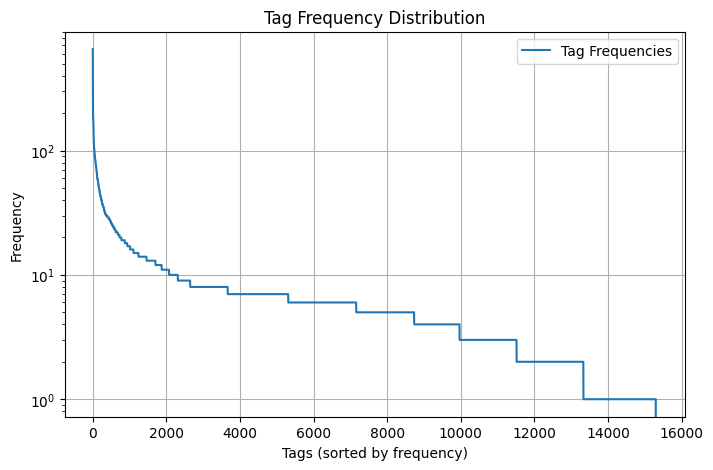

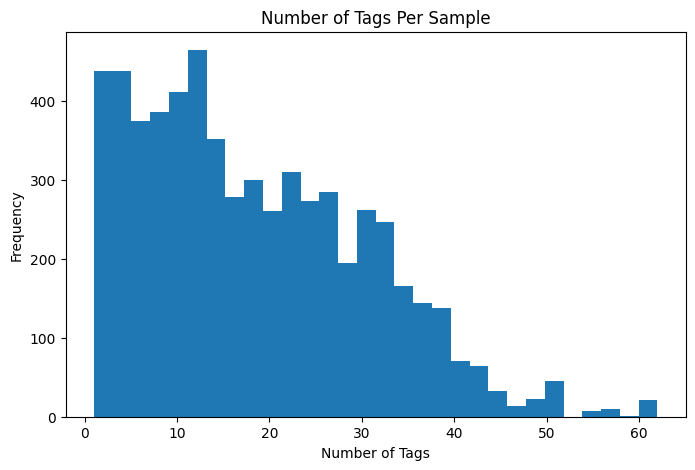

In [6]:
import matplotlib.pyplot as plt
import numpy as np

sample_tag_counts = np.sum(label_matrix_dense, axis=1)

matrix_density = np.sum(label_matrix_dense) / (n_samples * n_tags)

print(f"Number of unique tags: {n_tags}")
print(f"Average tags per sample: {sample_tag_counts.mean():.2f}")
print(f"Matrix density: {matrix_density:.6f}")

tag_frequencies = np.sum(label_matrix_dense, axis=0)

sorted_frequencies = np.sort(tag_frequencies)[::-1]
cumulative_frequencies = np.cumsum(sorted_frequencies) / sorted_frequencies.sum()

# 频率：长尾分布曲线
plt.figure(figsize=(8, 5))
plt.plot(sorted_frequencies, linestyle='-', label='Tag Frequencies')
plt.title("Tag Frequency Distribution")
plt.xlabel("Tags (sorted by frequency)")
plt.ylabel("Frequency")
plt.yscale('log')  # 对数缩放
plt.grid()
plt.legend()
plt.show()

# 视频标签数量分布
plt.figure(figsize=(8, 5))
plt.hist(sample_tag_counts, bins=30)
plt.title("Number of Tags Per Sample")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency")
plt.show()


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

# Text: TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000) # 限制feature数量
text_features = vectorizer.fit_transform(cleaned_data['text'])

# Category: One-Hot
encoder = OneHotEncoder(handle_unknown='ignore')
category_features = encoder.fit_transform(cleaned_data[['category_id']])
category_features *= (text_features.shape[1] / category_features.shape[1]) * 0.5 # 2:1的权重

combined_features = hstack([text_features, category_features])

print(f"Text features shape: {text_features.shape}")
print(f"Category features shape: {category_features.shape}")
print(f"Combined features shape: {combined_features.shape}")

Text features shape: (6000, 1000)
Category features shape: (6000, 15)
Combined features shape: (6000, 1015)


In [8]:
train_indices = train_data.index
test_indices = test_data.index

X_train = combined_features[train_indices, :]
X_test = combined_features[test_indices, :]

y_train = label_matrix_dense[train_indices, :]
y_test = label_matrix_dense[test_indices, :]

valid_labels = []
for i in range(y_train.shape[1]):
    unique_values = np.unique(y_train[:, i])
    if len(unique_values) > 1:  # 标签列需要至少两个类别
        valid_labels.append(i)

# 有效标签列
y_train_valid = y_train[:, valid_labels]
y_test_valid = y_test[:, valid_labels]

# 证明不会有显著过滤效果
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Valid training labels shape: {y_train_valid.shape}")
print(f"Valid Test labels shape: {y_test_valid.shape}")

y_train = y_train_valid
y_test = y_test_valid

Training features shape: (4800, 1015)
Test features shape: (1200, 1015)
Training labels shape: (4800, 15317)
Test labels shape: (1200, 15317)
Valid training labels shape: (4800, 14778)
Valid Test labels shape: (1200, 14778)


In [20]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm

def train_naive_bayes_with_progress(X_train, y_train, chunk_size=100):
    n_labels = y_train.shape[1]
    models = {}

    with tqdm(total=n_labels, desc="Training Naive Bayes") as pbar:
        for i in range(0, n_labels, chunk_size):
            end = min(i + chunk_size, n_labels)
            y_chunk = y_train[:, i:end]

            for j in range(y_chunk.shape[1]):
                label_index = i + j
                y_single = y_chunk[:, j]
                
                model = MultinomialNB()
                model.fit(X_train, y_single)
                models[label_index] = model
                
                pbar.update(1)
    
    return models

nb_models = train_naive_bayes_with_progress(X_train, y_train, chunk_size=100)


Training Naive Bayes: 100%|████████████████████████████████████████████████████| 14778/14778 [00:13<00:00, 1118.02it/s]


In [9]:
# Logistic Regression
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

def train_logistic_regression_with_progress(X_train, y_train, chunk_size=100):
    n_labels = y_train.shape[1]
    models = {}
    skipped_labels = []

    # 总的训练量是14778,即unique labels
    with tqdm(total=n_labels, desc="Training Logistic Regression") as pbar:
        for i in range(0, n_labels, chunk_size):
            end = min(i + chunk_size, n_labels)
            y_chunk = y_train[:, i:end]

            for j in range(y_chunk.shape[1]):
                label_index = i + j
                y_single = y_chunk[:, j]
                
                model = LogisticRegression(max_iter=1000, random_state=0)
                model.fit(X_train, y_single)
                models[label_index] = model
                
                pbar.update(1)
    
    return models

log_reg_models = train_logistic_regression_with_progress(X_train, y_train, chunk_size=100)

Training Logistic Regression: 100%|██████████████████████████████████████████████| 14778/14778 [03:55<00:00, 62.79it/s]


In [13]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

def train_random_forest_with_progress(X_train, y_train, chunk_size=100):
    n_labels = y_train.shape[1]
    models = {}

    with tqdm(total=n_labels, desc="Training Random Forest") as pbar:
        for i in range(0, n_labels, chunk_size):
            end = min(i + chunk_size, n_labels)
            y_chunk = y_train[:, i:end]

            for j in range(y_chunk.shape[1]):
                label_index = i + j
                y_single = y_chunk[:, j]
                
                model = RandomForestClassifier(n_estimators=15, max_depth=8, random_state=0)
                model.fit(X_train, y_single)
                models[label_index] = model
                
                pbar.update(1)
    
    return models

rf_models = train_random_forest_with_progress(X_train, y_train, chunk_size=1000)


Training Random Forest: 100%|████████████████████████████████████████████████████| 14778/14778 [03:02<00:00, 81.19it/s]


In [12]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

def train_knn_with_progress(X_train, y_train, chunk_size=100):
    n_labels = y_train.shape[1]
    models = {}

    with tqdm(total=n_labels, desc="Training KNN") as pbar:
        for i in range(0, n_labels, chunk_size):
            end = min(i + chunk_size, n_labels)
            y_chunk = y_train[:, i:end]

            for j in range(y_chunk.shape[1]):
                label_index = i + j
                y_single = y_chunk[:, j]
                
                model = KNeighborsClassifier(n_neighbors=5, metric='cosine')
                model.fit(X_train, y_single)
                models[label_index] = model

                pbar.update(1)
    
    return models

knn_models = train_knn_with_progress(X_train, y_train, chunk_size=100)

Training KNN: 100%|█████████████████████████████████████████████████████████████| 14778/14778 [00:20<00:00, 711.66it/s]


In [31]:
from sklearn.metrics import hamming_loss, accuracy_score, precision_recall_fscore_support
import numpy as np

def evaluate_models(models, X_test, y_test, model_name="Model"):
    n_samples, n_labels = y_test.shape
    y_pred = np.zeros_like(y_test)

    for label_index, model in models.items():
        y_pred[:, label_index] = model.predict(X_test)

    hamming = hamming_loss(y_test, y_pred)
    subset_accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

    print(f"Evaluation results for {model_name}:")
    print(f"Hamming Loss: {hamming:.4f}")
    print(f"Subset Accuracy: {subset_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("-" * 40)

    return {
        "hamming_loss": hamming, # 1 - 预测错误标签占比
        "subset_accuracy": subset_accuracy, # 完全预测正确向量数.对tags而言是不完全现实的
        "precision": precision, # 预测为正类的标签中正确的占比
        "recall": recall, # 对所有正类标签的预测覆盖程度
        "f1_score": f1, # Precision 和 Recall 的调和平均
    }
    
nb_metrics = evaluate_models(nb_models, X_test, y_test, model_name="Naive Bayes")
log_reg_metrics = evaluate_models(log_reg_models, X_test, y_test, model_name="Logistic Regression")
rf_metrics = evaluate_models(rf_models, X_test, y_test, model_name="Random Forest")
# knn_metrics = evaluate_models(knn_models, X_test, y_test, model_name="KNN")

all_metrics = {
    "Logistic Regression": log_reg_metrics,
    "Random Forest": rf_metrics,
    # "KNN": knn_metrics,
    "Naive Bayes": nb_metrics,
}

Evaluation results for Naive Bayes:
Hamming Loss: 0.0480
Subset Accuracy: 0.0000
Precision: 0.0173
Recall: 0.6934
F1-Score: 0.0337
----------------------------------------
Evaluation results for Logistic Regression:
Hamming Loss: 0.0010
Subset Accuracy: 0.0300
Precision: 0.9774
Recall: 0.1454
F1-Score: 0.2532
----------------------------------------
Evaluation results for Random Forest:
Hamming Loss: 0.0003
Subset Accuracy: 0.2875
Precision: 0.9926
Recall: 0.7949
F1-Score: 0.8828
----------------------------------------


In [28]:
from sklearn.metrics import hamming_loss, accuracy_score, precision_recall_fscore_support
import numpy as np

def evaluate_knn(knn_model, X_train, y_train, X_test, y_test):
    n_samples, n_labels = y_test.shape
    y_pred = np.zeros_like(y_test)

    # 逐样本预测
    for i in range(n_samples):
        # 获取最近邻的索引和距离
        distances, indices = knn_model.kneighbors(X_test[i].reshape(1, -1))
        # 聚合邻居的标签
        neighbor_labels = y_train[indices[0]]
        y_pred[i] = np.rint(neighbor_labels.mean(axis=0))

    hamming = hamming_loss(y_test, y_pred)
    subset_accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

    print("Evaluation results for KNN:")
    print(f"Hamming Loss: {hamming:.4f}")
    print(f"Subset Accuracy: {subset_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("-" * 40)

    return {
        "hamming_loss": hamming,
        "subset_accuracy": subset_accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
    }

knn_metrics = evaluate_knn(knn_models[0], X_train, y_train, X_test, y_test)


Evaluation results for KNN:
Hamming Loss: 0.0004
Subset Accuracy: 0.7300
Precision: 0.8816
Recall: 0.7978
F1-Score: 0.8376
----------------------------------------


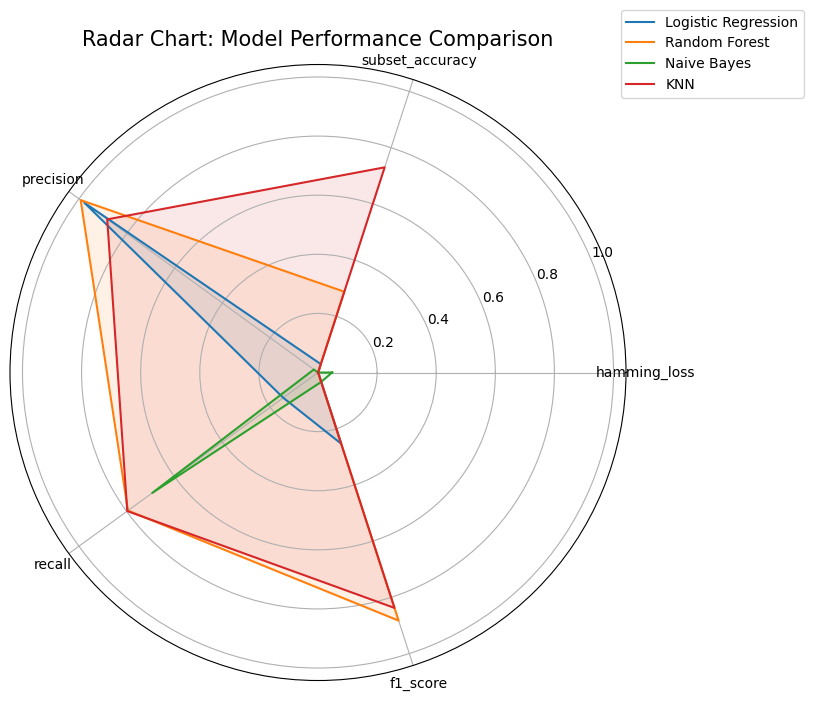

In [33]:
from math import pi

all_metrics = {
    "Logistic Regression": log_reg_metrics,
    "Random Forest": rf_metrics,
    "Naive Bayes": nb_metrics,
    "KNN": knn_metrics,
}

labels = metrics
num_vars = len(labels)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

for model, model_metrics in all_metrics.items():
    values = [model_metrics[metric] for metric in labels]
    values += values[:1]
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.1)

ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title("Radar Chart: Model Performance Comparison", size=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()